In [4]:
import pandas as pd
import numpy as np

data_cu_2=pd.read_csv('../Data/01_Courses_usagers/2023_02/All_data_courses.csv', sep=";")
data_remp_2=pd.read_csv('../Data/02_Historique_remplissage_stations/2023_02/All_data_remplissage.csv', sep=",")
data_mouv_2=pd.read_excel('../Data/03_Régulation_mouvements_stations/2023_02/2023-02-01_Mouvements_de_régulation.xlsx')

Création d'un dataframe indiquant le nombre de départ et le nombre d'arrivées par station

In [5]:
data_cu_2=data_cu_2[data_cu_2['is_VAE'] == False]

# Compter le nombre de départs par station
depart_counts = data_cu_2['from_stat'].value_counts()

# Compter le nombre d'arrivées par station
arrivee_counts = data_cu_2['to_stat'].value_counts()

# Créer un dataframe avec les stations, le nombre de départs et le nombre d'arrivées
activite_station = pd.DataFrame({
    'Station': depart_counts.index,
    'Nb_departs': depart_counts.values,
    'Nb_arrivees': arrivee_counts.reindex(depart_counts.index, fill_value=0).values
})

activite_station['remplissage']=activite_station['Nb_arrivees']-activite_station['Nb_departs'] #correspond au nombre de vélos en + ou en - sur 6 mois
activite_station

,Station,Nb_departs,Nb_arrivees,remplissage
0,Richard Lenoir - Place de la Bastille,5110,5132,22
1,Gare de Lyon - Place Louis Armand,4985,5109,124
2,Place Mireille Havet,4914,4862,-52
3,Gare Saint-Lazare - Cour du Havre,4799,4845,46
4,Traversière - Ledru-Rollin,4109,4175,66
...,...,...,...,...
1417,Place Centrale,4,22,18
1418,Sèvres Rive Gauche,3,4,1
1419,11 Novembre 1918 - 8 Mai 1945,2,6,4
1420,Stade Pershing,1,1,0


Idée: faire des couples de stations avec une en remplissage négatif et une remplissage positive. Les couples seront formés en fonction de leur distance où la distance corrospond à la latitude, la longitude et la valeur absolue de remplissage; avec ces 3 données centrées réduites. Il faut adapter le code pour avoir un remplissage celon le type de vélo. Problème: si une station à un remplissage négatif pour les vélos électriques et positif pour les autres vélos, il faut faire un aller-retour. Solution former des couples par type de vélo. Remarque: la latitude et la longitude ne sont pas des bons représentatifs de distance car les navettes ne se déplacent pas en distance euclidienne, la durée et la distance parcourue peuvent donner un meilleur apercu de la distance à parcourir par la navette.

In [6]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance_matrix

features=['remplissage', 'Latitude station prise', 'Longitude station prise']
# Séparer les stations en fonction du remplissage
stations_remplissage = activite_station[activite_station['remplissage'] > 0].copy()
stations_vidage = activite_station[activite_station['remplissage'] < 0].copy()
stations_vidage['remplissage']=np.abs(stations_vidage['remplissage'])

In [7]:
stations = data_cu_2.loc[:, ['from_stat', 'Latitude_start', 'longitude_start']].drop_duplicates().reset_index(drop=True)
stations = stations.rename(columns={'from_stat': 'nom', 'Latitude_start': 'latitude', 'longitude_start': 'longitude'})
stations

,nom,latitude,longitude
0,Censier - Jardin des Plantes,48.841072,2.355475
1,Diderot - Reuilly,48.847208,2.386127
2,Jean Macé - Faidherbe,48.853375,2.382862
3,Dugommier,48.838811,2.389658
4,Belfort - Voltaire,48.856336,2.382990
...,...,...,...
1445,Commerce - Letellier,48.847271,2.296863
1446,Place Alphonse Deville,48.850188,2.327596
1447,Dupleix - du Guesclin,48.851477,2.296670
1448,Hôpital Européen Georges Pompidou,48.838147,2.274938


Dans la suite du problème il est important que les sommes des fréquences de remplissage s'équilibrent pour faire 0

In [8]:
stations_remplissage = stations_remplissage.sample(n=15)
n = stations_remplissage.remplissage.sum()

stations_vidage2 = pd.DataFrame(columns=stations_vidage.columns)

while stations_vidage2.remplissage.sum() != n:
    while stations_vidage2['remplissage'].sum() < n:
        stations_vidage2 = pd.concat([stations_vidage2, stations_vidage.sample(1)], ignore_index=True)
        
    while stations_vidage2.remplissage.sum() > n:
        stations_vidage2 = stations_vidage2.drop(stations_vidage2.sample(1).index)

stations_vidage=stations_vidage2
stations_remplissage=stations_remplissage.reset_index(drop=True)
stations_vidage=stations_vidage.reset_index(drop=True)

In [9]:
stations_remplissage.remplissage.sum(), stations_remplissage.remplissage.sum()

(364, 364)

In [10]:
pos_station_vidage = stations.loc[stations['nom'].isin(stations_vidage['Station']), :]
pos_station_remplissage = stations.loc[stations['nom'].isin(stations_remplissage['Station']), :]

pos_station_remplissage=pos_station_remplissage.drop_duplicates(subset=['nom']).reset_index(drop=True)
pos_station_vidage=pos_station_vidage.drop_duplicates(subset=['nom']).reset_index(drop=True)

pos_station_vidage

,nom,latitude,longitude
0,Lourmel - Marie Skobtsov,48.844974,2.287283
1,Président Wilson - Jean Jaures,48.890341,2.292068
2,Glacière - Soeur Catherine Marie,48.829523,2.343570
3,Lemercier - Cardinet,48.890097,2.317378
4,Choisy - Malmaisons,48.821920,2.363347
5,Cherche-Midi - Hôpital Necker,48.844611,2.317914
6,Place du Président Salvador Allende,48.897307,2.400792
7,Vinaigriers - Magenta,48.873117,2.359305
8,Paul Bodin - Clichy,48.892396,2.317143
9,Assemblée Nationale,48.861411,2.320121


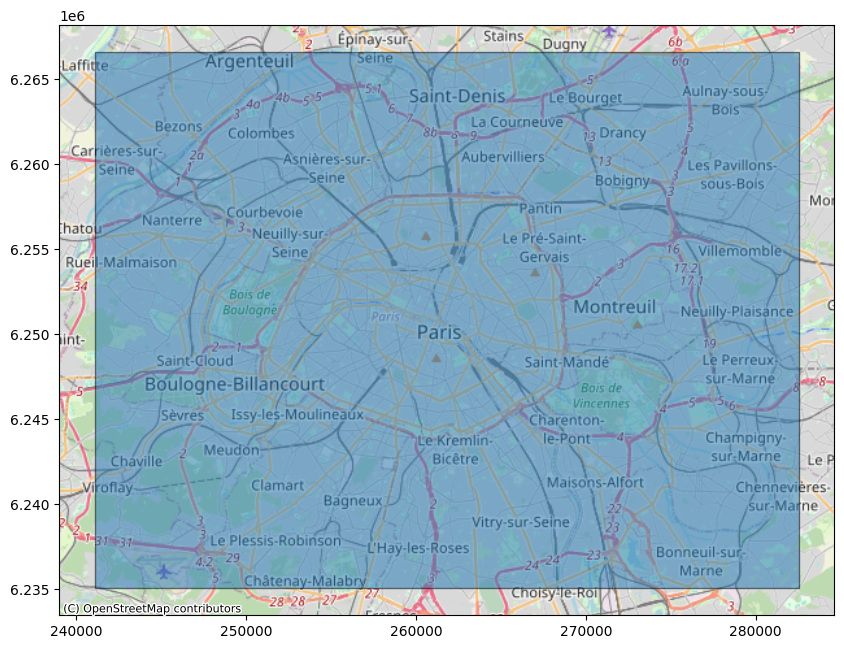

In [11]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as pl
from shapely.geometry import box

bbox = (stations.longitude.min(), stations.latitude.min(), stations.longitude.max(), stations.latitude.max())
geometry = [box(*bbox)]
gdf = gpd.GeoDataFrame({'geometry': geometry}, crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
pl.savefig('paris_map.png')
pl.show()

Text(0.5, 1.0, 'stations de vélos')

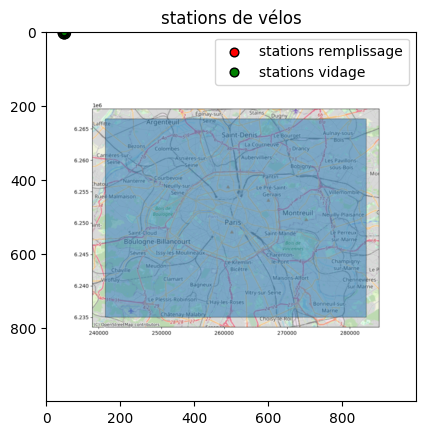

In [12]:
import pylab as pl
import ot
import time
import matplotlib.image as mpimg

r_remplissage=pd.to_numeric(stations_remplissage['remplissage'])
v_remplissage=pd.to_numeric(stations_vidage['remplissage'])
lat_remplissage=pos_station_remplissage['latitude'].values
long_remplissage=pos_station_remplissage['longitude'].values
lat_vidage=pos_station_vidage['latitude'].values
long_vidage=pos_station_vidage['longitude'].values

paris_map = mpimg.imread('paris_map.png')
#pl.figure(1,(7,6))
pl.clf()
pl.imshow(paris_map, interpolation='bilinear')
pl.scatter(lat_remplissage, long_remplissage, s=r_remplissage, c='red', ec='k', label='stations remplissage')
pl.scatter(lat_vidage, long_vidage, s=v_remplissage, c='green', ec='k', label='stations vidage')
pl.legend()
pl.title('stations de vélos')

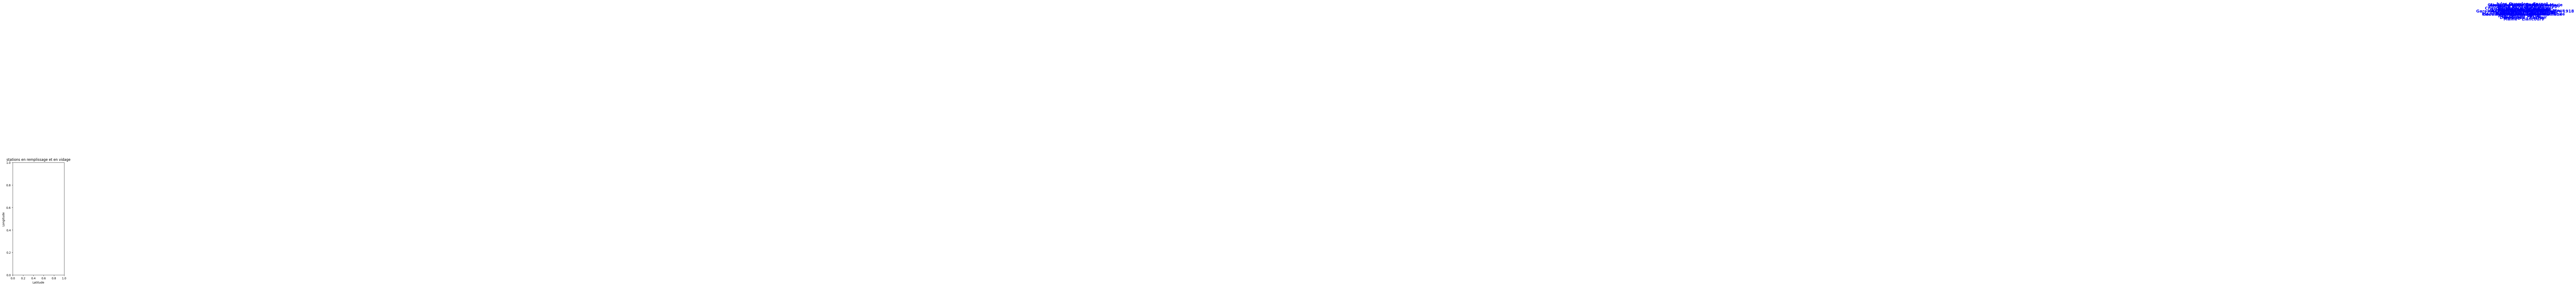

In [13]:
C = ot.dist(pos_station_remplissage[['latitude','longitude']].values, pos_station_vidage[['latitude','longitude']].values)

f1 = pl.figure(1, (7,7))
pl.clf()
pl.subplot(121)
#pl.imshow(Imap, interpolation='bilinear')
for i in range(len(stations_vidage)):
    pl.text(pos_station_vidage.loc[i, 'latitude'], pos_station_vidage.loc[i, 'longitude'], stations_vidage.Station[i], color='blue', fontsize=14, fontweight='bold', ha='center', va='center')
for i in range(len(stations_remplissage)):
    pl.text(pos_station_remplissage.loc[i, 'latitude'], pos_station_remplissage.loc[i, 'longitude'], stations_remplissage.Station[i], color='blue', fontsize=14, fontweight='bold', ha='center', va='center')
pl.title('stations en remplissage et en vidage')
pl.xlabel('Latitude')
pl.ylabel('Longitude')
pl.show()

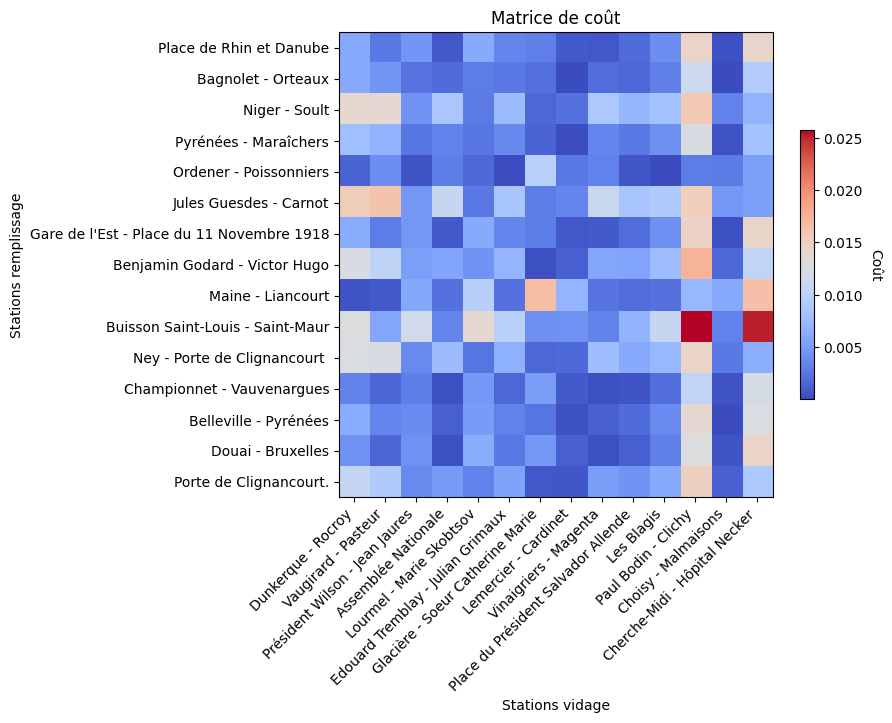

In [14]:
f2 = pl.figure(2, (7, 7))
pl.clf()
im = pl.imshow(C, cmap='coolwarm')
pl.title('Matrice de coût')
pl.xticks(ticks=np.arange(len(stations_vidage)), labels=stations_vidage['Station'], rotation=45, ha='right')
pl.yticks(ticks=np.arange(len(stations_remplissage)), labels=stations_remplissage['Station'])
cbar = pl.colorbar(im, shrink=0.5)
cbar.ax.set_ylabel("Coût", rotation=-90, va="bottom")
pl.xlabel('Stations vidage')
pl.ylabel('Stations remplissage')
pl.savefig('matrice_de_cout_ne')
pl.show()

In [15]:
start = time.time()
ot_emd = ot.emd(stations_remplissage['remplissage'].values, stations_vidage['remplissage'].values, C)
time_emd = time.time() - start

C:\Users\jinsn\AppData\Local\Temp\ipykernel_28692\953569336.py:2: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  ot_emd = ot.emd(stations_remplissage['remplissage'].values, stations_vidage['remplissage'].values, C)


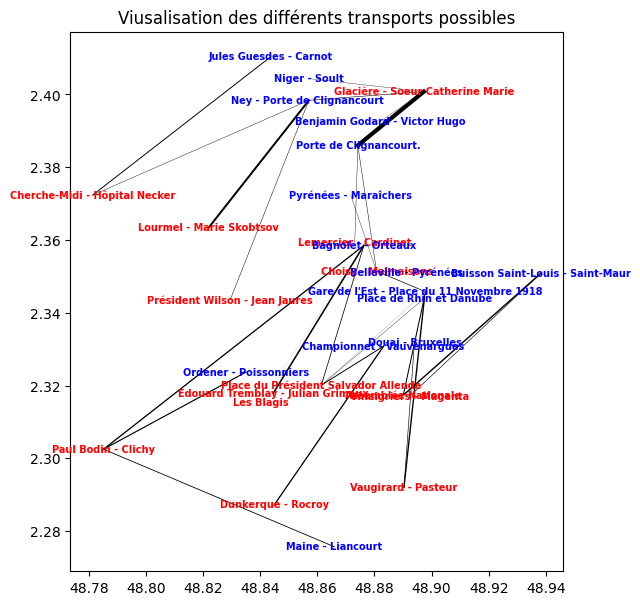

In [16]:
f = pl.figure(3, (14,7))
pl.clf()
pl.subplot(121)
#pl.imshow(paris_map, interpolation='bilinear')
for i in range(len(pos_station_remplissage)):
    for j in range(len(pos_station_vidage)):
        pl.plot([pos_station_remplissage.loc[i,'latitude'], pos_station_vidage.loc[j,'latitude']], [pos_station_remplissage.loc[i,'longitude'], pos_station_vidage.loc[j,'longitude']], '-k', lw=3. * ot_emd[i, j] / ot_emd.max())
for i in range(len(pos_station_vidage)):
    pl.text(pos_station_vidage.loc[i, 'latitude'], pos_station_vidage.loc[i, 'longitude'], stations_vidage.Station[i], color='red', fontsize=7, fontweight='bold', ha='center', va='center')
for i in range(len(pos_station_remplissage)):
    pl.text(pos_station_remplissage.loc[i, 'latitude'], pos_station_remplissage.loc[i, 'longitude'], stations_remplissage.Station[i], color='blue', fontsize=7, fontweight='bold', ha='center', va='center')
pl.title('Viusalisation des différents transports possibles')
pl.savefig('trajets_transports_ne')

In [17]:
pos_station_vidage

,nom,latitude,longitude
0,Lourmel - Marie Skobtsov,48.844974,2.287283
1,Président Wilson - Jean Jaures,48.890341,2.292068
2,Glacière - Soeur Catherine Marie,48.829523,2.343570
3,Lemercier - Cardinet,48.890097,2.317378
4,Choisy - Malmaisons,48.821920,2.363347
5,Cherche-Midi - Hôpital Necker,48.844611,2.317914
6,Place du Président Salvador Allende,48.897307,2.400792
7,Vinaigriers - Magenta,48.873117,2.359305
8,Paul Bodin - Clichy,48.892396,2.317143
9,Assemblée Nationale,48.861411,2.320121


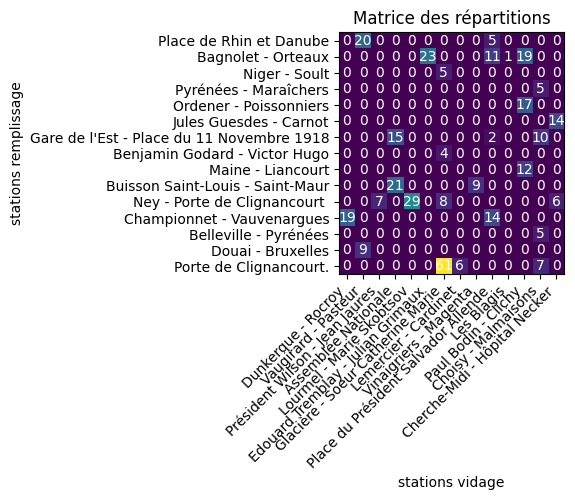

In [18]:
ax = pl.subplot(122)
im = pl.imshow(ot_emd)
for i in range(len(stations_remplissage)):
    for j in range((len(stations_vidage))):
        text = ax.text(j, i, '{0:g}'.format(ot_emd[i, j]), ha="center", va="center", color="w")
pl.xticks(ticks=np.arange(len(stations_vidage)), labels=stations_vidage['Station'], rotation=45, ha='right')
pl.yticks(ticks=np.arange(len(stations_remplissage)), labels=stations_remplissage['Station'])
pl.title('Matrice des répartitions')

pl.xlabel('stations vidage')
pl.ylabel('stations remplissage')
pl.savefig('Matrice_repartitions_ne')